In [96]:
import torch
import numpy as np
from imageio.v3 import imread, imwrite
from FastGeodis import generalised_geodesic2d, geodesic2d_fastmarch
import matplotlib.pyplot as plt

In [97]:
assert torch.cuda.is_available()

In [98]:
IMAGE = "0027"
INPUT_IMG_FILENAME = f"/data/ecssd/gray_png/{IMAGE}.png"
INPUT_MASK_FILENAME = f"/data/ecssd/masks/{IMAGE}.png"

In [99]:
if len(INPUT_IMG_FILENAME) > 0:
    img = torch.from_numpy(imread(INPUT_IMG_FILENAME).astype(np.float32)).unsqueeze_(0).unsqueeze_(0)
else:
    img = torch.zeros((1, 1, 40, 50))
mask = None
if len(INPUT_MASK_FILENAME) > 0:
    mask = torch.from_numpy((imread(INPUT_MASK_FILENAME) < 1).astype(np.float32)).unsqueeze_(0).unsqueeze_(0)
else:
    mask = torch.ones_like(img)
    mask[..., 20:30, 20:43] = 0
assert(img.shape == mask.shape)

In [100]:
img = img.to("cuda")
mask = mask.to("cuda")

In [113]:
v = 1e10
lamb = 0.5 # Geodesic distance
iterations = 8

In [114]:
geo_dist_prev = generalised_geodesic2d(img, mask, v, lamb, iterations)
geo_dist = generalised_geodesic2d(img, mask, v, lamb, iterations + 5)

In [115]:
geo_dist_prev = np.squeeze(geo_dist_prev.cpu().numpy())
geo_dist = np.squeeze(geo_dist.cpu().numpy())

In [116]:
np.allclose(geo_dist_prev, geo_dist)

False

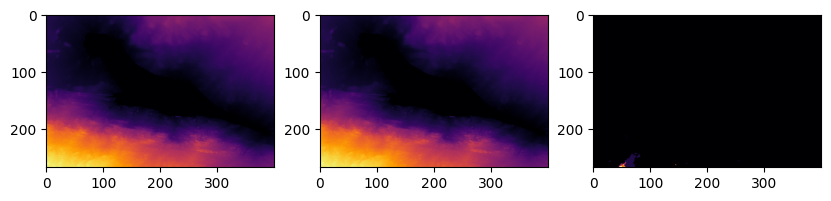

In [117]:
vmin = min(geo_dist.min(), geo_dist_prev.min())
vmax = max(geo_dist.max(), geo_dist_prev.max())
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(geo_dist_prev, cmap="inferno", vmin=vmin, vmax=vmax)
plt.subplot(132)
plt.imshow(geo_dist, cmap="inferno", vmin=vmin, vmax=vmax)
plt.subplot(133)
plt.imshow(np.abs(geo_dist - geo_dist_prev), cmap="inferno")
plt.show()

In [118]:
from matplotlib.colors import Normalize
from matplotlib.cm import inferno

In [119]:
def propagation_image(img, th):
    # Normalize and colorize
    norm = Normalize(img.min(), img.max())
    normalized = norm(img)
    colored = (inferno(normalized) * 255).astype(np.uint8)

    return colored

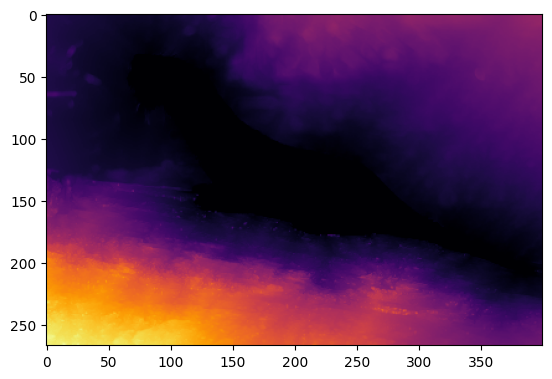

In [120]:
plt.imshow(propagation_image(geo_dist, 300))

In [121]:
imwrite("it_8.png", propagation_image(geo_dist, 0))